# Data collection from quantrocket

In [ ]:
# first create an empty database
from quantrocket.history import create_usstock_db
create_usstock_db("usstock-free-1d", bar_size="1 day", free=True)

In [ ]:
# from the collect_histroy library, fill the database with values
from quantrocket.history import collect_history
collect_history("usstock-free-1d")

In [ ]:
#get the securities
from quantrocket.master import get_securities
securities = get_securities(vendors="usstock", sec_types="STK")
securities.head()

In [ ]:
# create a universe for securities
from quantrocket.master import create_universe
create_universe("usstock-free", sids=securities.index.tolist())

In [ ]:
# create a security called filtered_securities which is a subset of securities
filtered_securities = securities[securities.Delisted==False]
filtered_securities = filtered_securities[["Symbol", "Exchange", "Name", "Delisted"]]
filtered_securities.head()

In [ ]:
#create universe for filtered securities
create_universe("usstock-free-active", sids=filtered_securities.index.tolist())


In [ ]:
#retrieve sid for AAPL and download the data as a CSV file from start to end date with only close stock prices
from quantrocket.history import download_history_file
sid_aapl = "FIBBG000B9XRY4"
download_history_file("usstock-free-1d",start_date="2023-01-01",end_date="2023-12-31",sids=sid_aapl,fields=["Close"],filepath_or_buffer="stockPrices.csv")

# Portfolio calculation - pre specified logic





## Install necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
df = pd.read_csv('/content/stockPrices.csv')
print(df)

                Sid        Date     Close
0    FIBBG000B9XRY4  03-01-2023  124.2163
1    FIBBG000B9XRY4  04-01-2023  125.4975
2    FIBBG000B9XRY4  05-01-2023  124.1666
3    FIBBG000B9XRY4  06-01-2023  128.7352
4    FIBBG000B9XRY4  09-01-2023  129.2616
..              ...         ...       ...
245  FIBBG000B9XRY4  22-12-2023  193.3533
246  FIBBG000B9XRY4  26-12-2023  192.8040
247  FIBBG000B9XRY4  27-12-2023  192.9038
248  FIBBG000B9XRY4  28-12-2023  193.3333
249  FIBBG000B9XRY4  29-12-2023  192.2846

[250 rows x 3 columns]


In [ ]:
df.drop(['Sid'],axis=1)

,Date,Close
0,03-01-2023,124.2163
1,04-01-2023,125.4975
2,05-01-2023,124.1666
3,06-01-2023,128.7352
4,09-01-2023,129.2616
...,...,...
245,22-12-2023,193.3533
246,26-12-2023,192.8040
247,27-12-2023,192.9038
248,28-12-2023,193.3333


## Calculate returns

In [ ]:
# Calculate return by using the percentage of close price
df['Return'] = df['Close'].pct_change()

## Defining the states and finding maximum portfolio value

In [ ]:
def find_state(x):
    if x >= 0.01:
        return 1
    elif x > -0.01:
        return 0
    else:
        return -1

df['state'] = df['Return'].apply(find_state)
#initial portfolio value as 0
V=0
buy_indices=[]
for i in range(1,len(df)):
  if df.loc[i,'state']==1 and df.loc[i-1,'state']==0: #if current state is bull and prev state is flat, then increase portfolio value by 1
    V+=1
    buy_indices.append(i)
  elif df.loc[i,'state']==-1 and df.loc[i-1,'state']==0:  #if current state is bear and prev state is flat, then decrease portfolio value by 1
    V-=1
    buy_indices.append(i)
print("Portfolio value: ",V)
print("Buy indices: ",buy_indices)

#writing into a output.txt file
with open("output.txt", "w") as f:
    f.write("Maximum portfolio value: {}\n".format(V))
    f.write("Buy indices: {}\n".format(buy_indices))

Portfolio value:  17
Buy indices:  [6, 8, 12, 16, 21, 28, 30, 33, 36, 39, 41, 45, 50, 52, 57, 59, 61, 64, 66, 69, 79, 85, 88, 94, 97, 100, 103, 108, 110, 113, 117, 120, 123, 128, 133, 136, 142, 145, 147, 154, 156, 160, 164, 169, 173, 177, 179, 183, 187, 191, 196, 201, 204, 207, 209, 212, 216, 218, 232, 234, 236, 238, 243]


## Transition probability distribution

In [ ]:
def transition_probability_matrix(states):
    num_states = len(set(states))
    transition_matrix = np.zeros((num_states, num_states))
    # Count transitions
    for i in range(1,len(states) ):
        current_state = states[i-1]
        next_state = states[i]
        transition_matrix[current_state, next_state] += 1
    # Normalize counts to obtain probabilities
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = transition_matrix / row_sums
    return transition_matrix

states = df['state']
print(set(states))
# Calculate transition probability matrix
transition_matrix = transition_probability_matrix(states)

print("Transition Probability Matrix:")
print(transition_matrix)

#from-to states of transition probability matrix
transitions = []
for i in range(1, len(states)):
    transitions.append((states[i - 1], states[i]))
transition_df = pd.DataFrame(transitions, columns=['From', 'To'])
transition_probabilities = transition_df.groupby(['From', 'To']).size().unstack().fillna(0)
transition_probabilities = transition_probabilities.div(transition_probabilities.sum(axis=1), axis=0)

print("Transition Probabilities:")
print(transition_probabilities)

{0, 1, -1}
Transition Probability Matrix:
[[0.59872611 0.25477707 0.14649682]
 [0.67857143 0.19642857 0.125     ]
 [0.72222222 0.13888889 0.13888889]]
Transition Probabilities:
To          -1         0         1
From                              
-1    0.138889  0.722222  0.138889
 0    0.146497  0.598726  0.254777
 1    0.125000  0.678571  0.196429


In [111]:
transition_matrix =[[ 0.138889  ,0.722222,  0.138889],
    [0.146497  ,0.598726  ,0.254777],
     [0.125000,  0.678571,  0.196429]]
P_1 = np.linalg.matrix_power(transition_matrix, 2)
print(P_1)

[[0.14245464 0.62696783 0.23057754]
 [0.13990551 0.63716046 0.22293403]
 [0.14132337 0.62984687 0.22882976]]


Text(0, 0.5, 'Close Price')

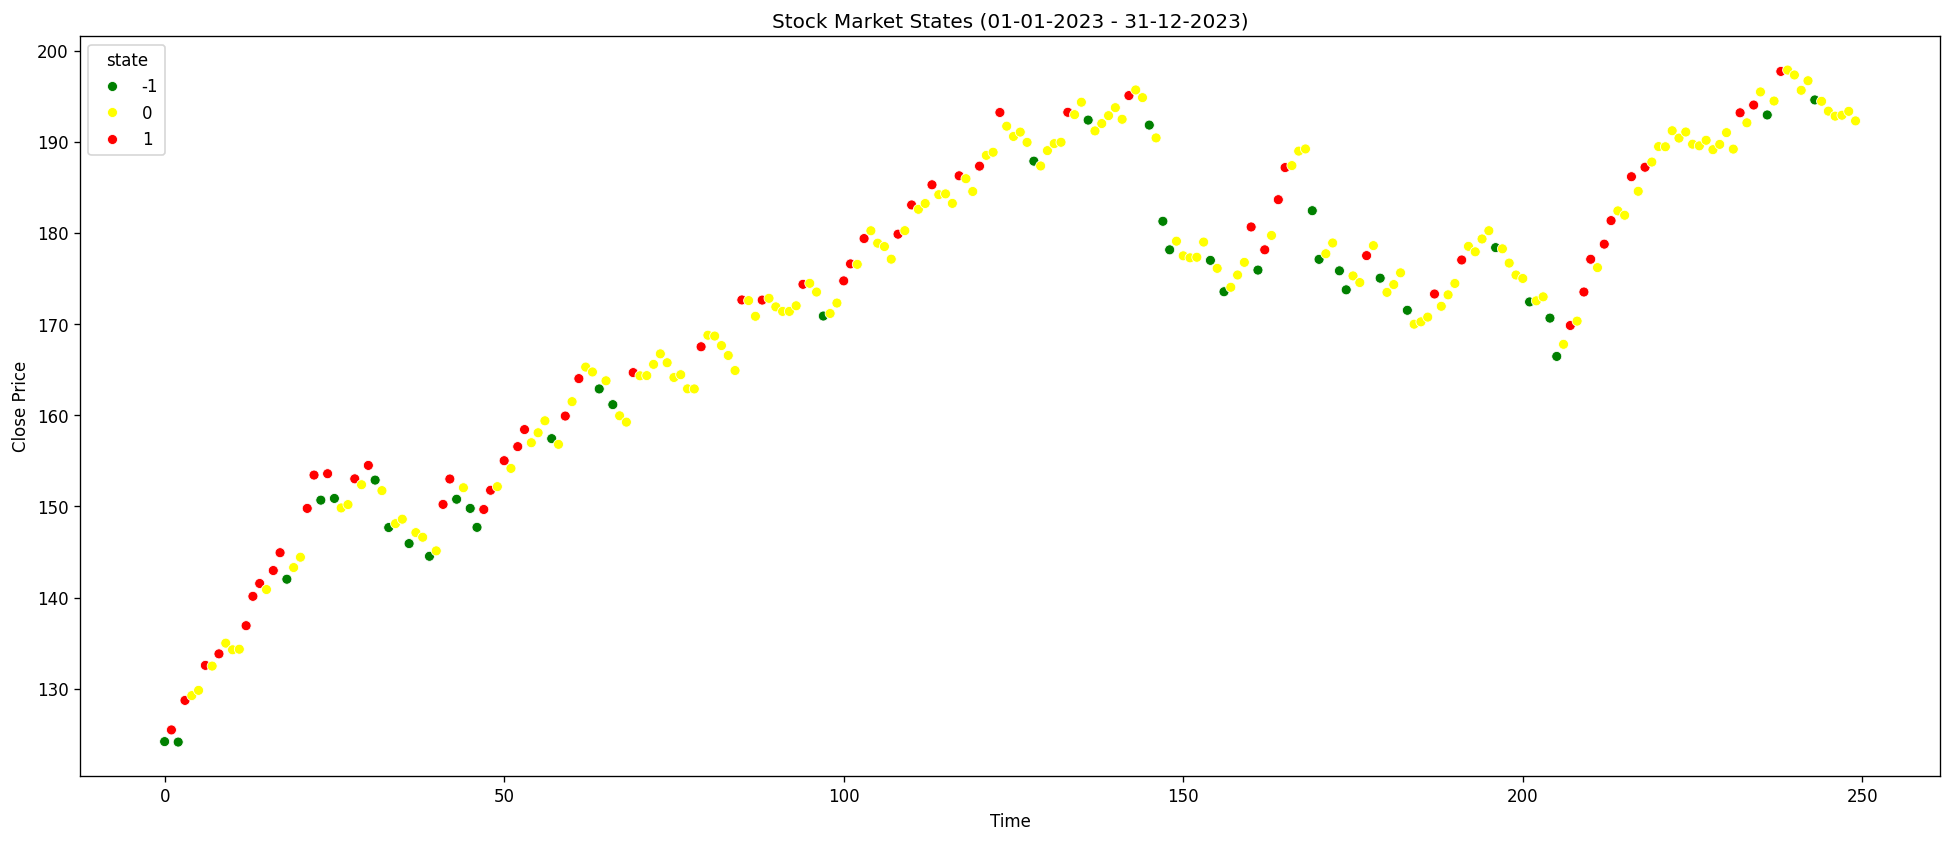

In [ ]:
# Plot states from 03-01-2023 - 29-12-2023
colors = {1:'red', -1:'green', 0:'yellow'}
plt.figure(figsize = (20,8))
sns.scatterplot(x = df.index, y = df['Close'], palette=colors, hue = df['state'])
plt.title('Stock Market States (01-01-2023 - 31-12-2023)')
plt.xlabel('Time')
plt.ylabel('Close Price')

## Check for stationary distribution

In [ ]:
import numpy as np
def check_convergence(matrix, iterations=100):
    for _ in range(iterations):
        matrix = np.dot(matrix, matrix)
        if np.allclose(matrix, matrix @ matrix):
            return matrix
    return None

limiting_matrix = check_convergence(transition_matrix)
if limiting_matrix is not None:
    print("Converged to limiting distribution:")
    print(limiting_matrix)
    # Extract the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(limiting_matrix)
    for i, eigenvalue in enumerate(eigenvalues):
        if np.isclose(eigenvalue, 1):
            limiting_distribution = eigenvectors[:, i]
            limiting_distribution /= np.sum(limiting_distribution)
            print("Limiting distribution:", limiting_distribution)
            break
else:
    print("Did not converge within the specified iterations.")


Converged to limiting distribution:
[[0.63407971 0.22533705 0.14058324]
 [0.6340797  0.22533706 0.14058324]
 [0.6340797  0.22533706 0.14058324]]
Limiting distribution: [0.33333333 0.33333333 0.33333333]


[0.29943496 0.3393672  0.36119784]


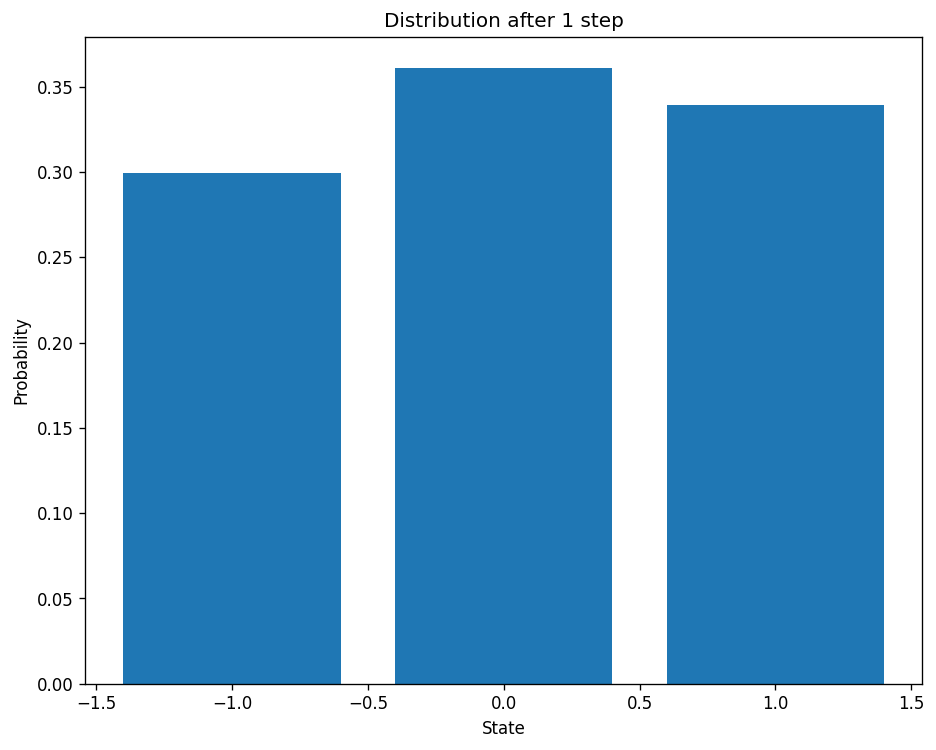

In [ ]:
P_1 = np.linalg.matrix_power(transition_matrix, 1)
dist = np.dot(P_1, [1, 0, 0])
dist = dist / np.sum(dist)
print(dist)
states = [-1, 1, 0]
import matplotlib.pyplot as plt
plt.bar(states, dist)
plt.title("Distribution after 1 step")
plt.xlabel("State")
plt.ylabel("Probability")
plt.show()

[[0.63716066 0.22293396 0.13990538]
 [0.62984703 0.22882974 0.14132324]
 [0.62696798 0.23057753 0.14245449]]
[0.33641438 0.33255286 0.33103275]


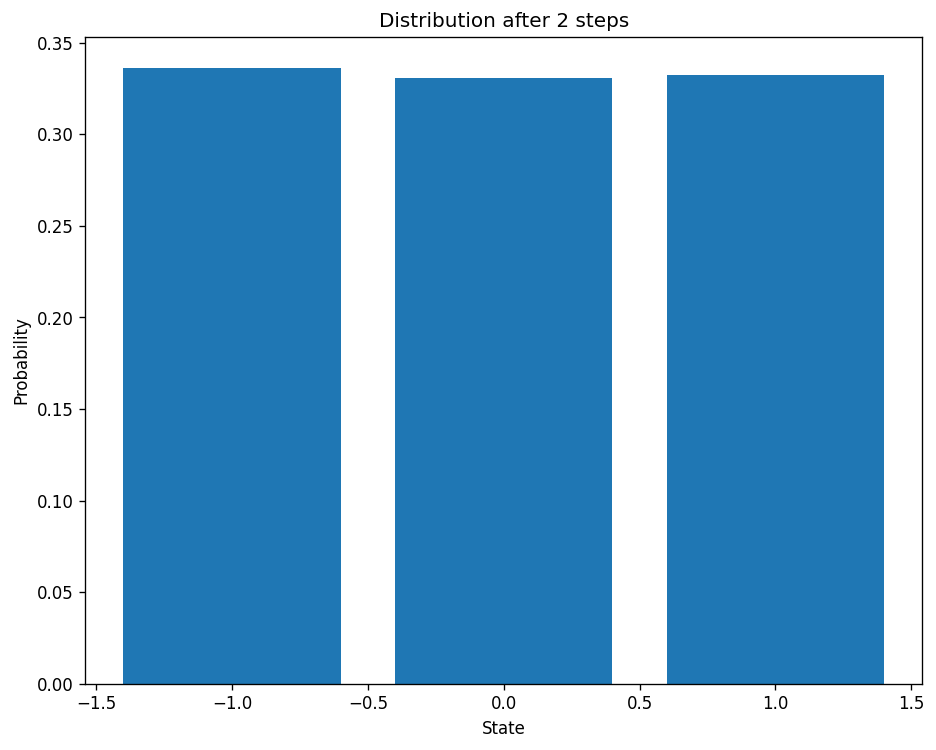

In [110]:
P_2 = np.linalg.matrix_power(transition_matrix, 2)
print(P_2)
dist = np.dot(P_2, [1, 0, 0])
dist = dist / np.sum(dist)
print(dist)
states = [-1, 1, 0]
import matplotlib.pyplot as plt
plt.bar(states, dist)
plt.title("Distribution after 2 steps")
plt.xlabel("State")
plt.ylabel("Probability")
plt.show()

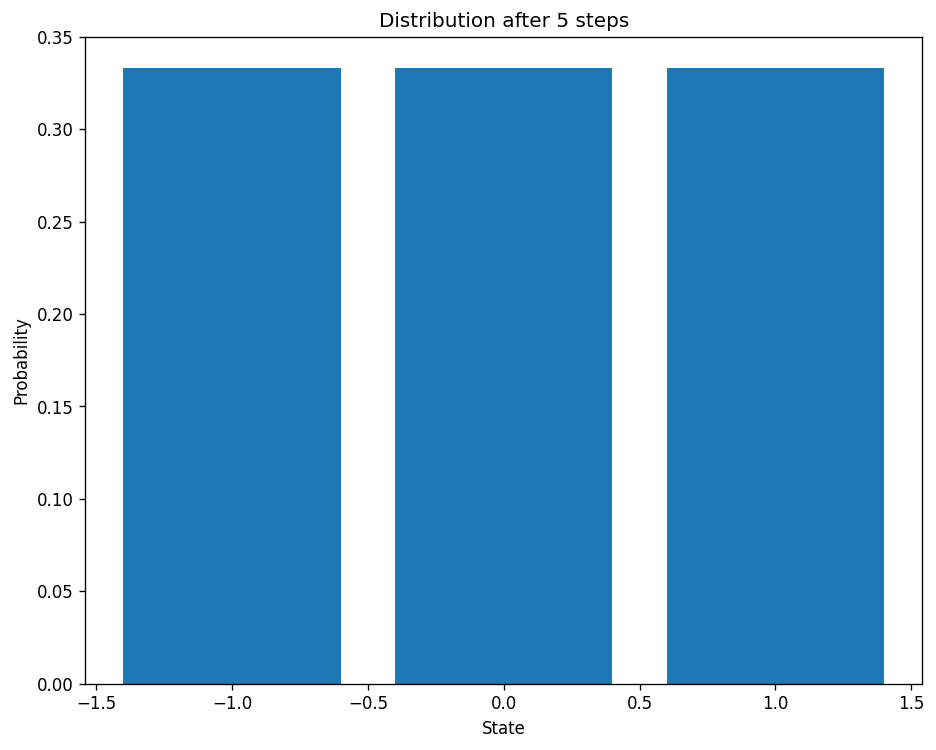

In [ ]:
P_5 = np.linalg.matrix_power(transition_matrix, 5)
dist = np.dot(P_5, [1, 0, 0])
dist = dist / np.sum(dist)
states = [-1, 1, 0]
import matplotlib.pyplot as plt
plt.bar(states, dist)
plt.title("Distribution after 5 steps")
plt.xlabel("State")
plt.ylabel("Probability")
plt.show()

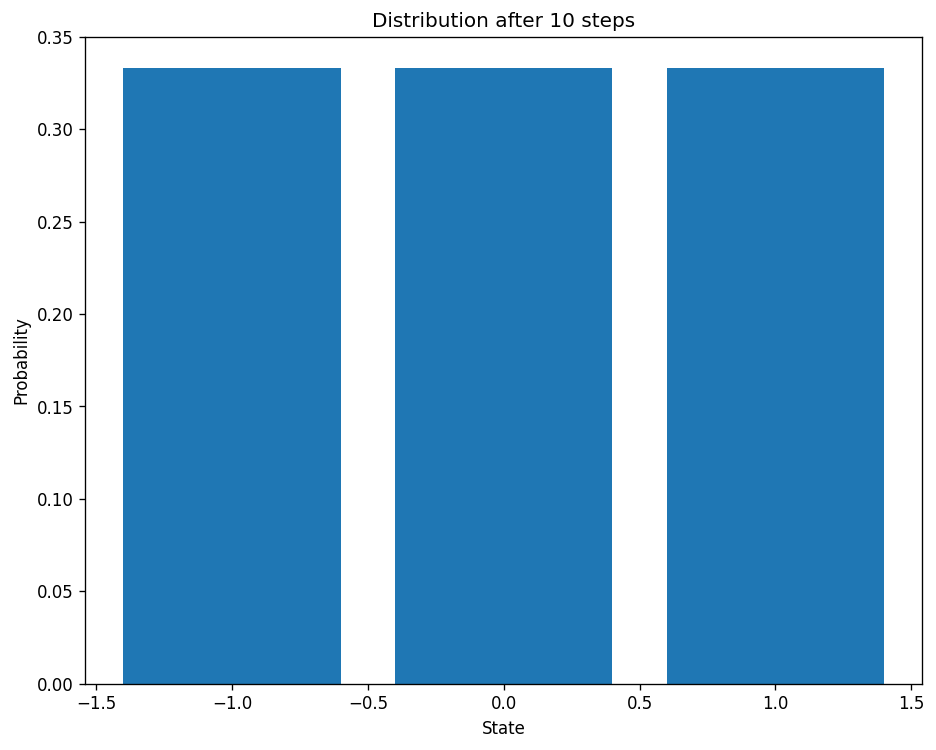

In [ ]:
P_10 = np.linalg.matrix_power(transition_matrix, 10)
dist = np.dot(P_10, [1, 0, 0])
dist = dist / np.sum(dist)
states = [-1, 1, 0]
import matplotlib.pyplot as plt
plt.bar(states, dist)
plt.title("Distribution after 10 steps")
plt.xlabel("State")
plt.ylabel("Probability")
plt.show()

# Visualizations and Forecasting using ARIMA model

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
!pip install pmdarima

## Augmented Dickey-Fuller

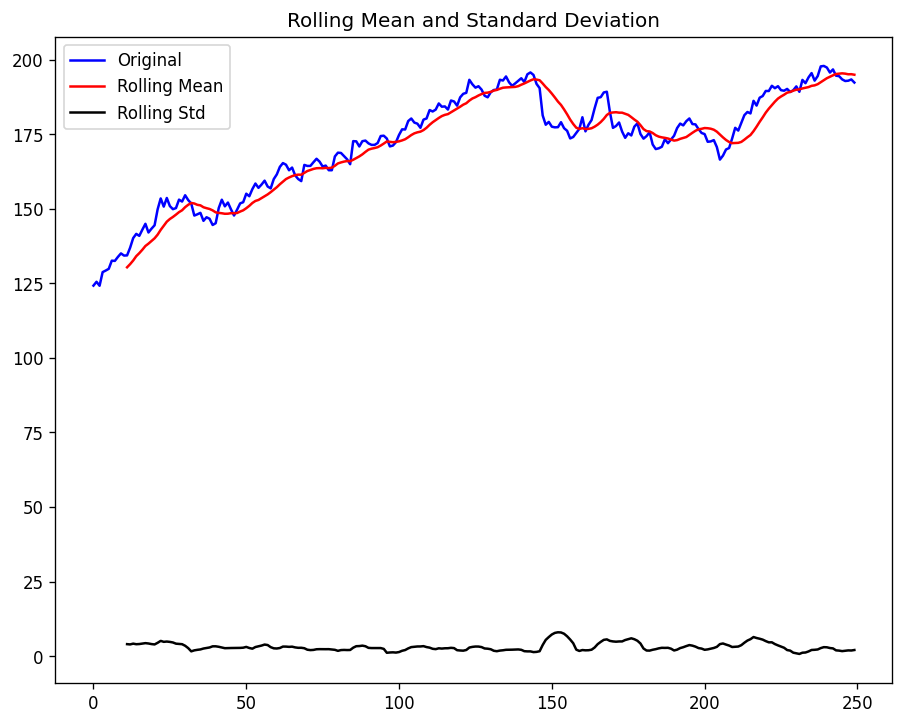

Results of dickey fuller test
Test Statistics                 -2.586133
p-value                          0.095897
No. of lags used                 0.000000
Number of observations used    249.000000
critical value (1%)             -3.456888
critical value (5%)             -2.873219
critical value (10%)            -2.572994
dtype: float64


In [ ]:
#Test for staionarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

here as p-value is greater tha  0.05, we perform differencing technique(i.e) convert it into a stationary time series model

Text(0, 0.5, 'Close Price')

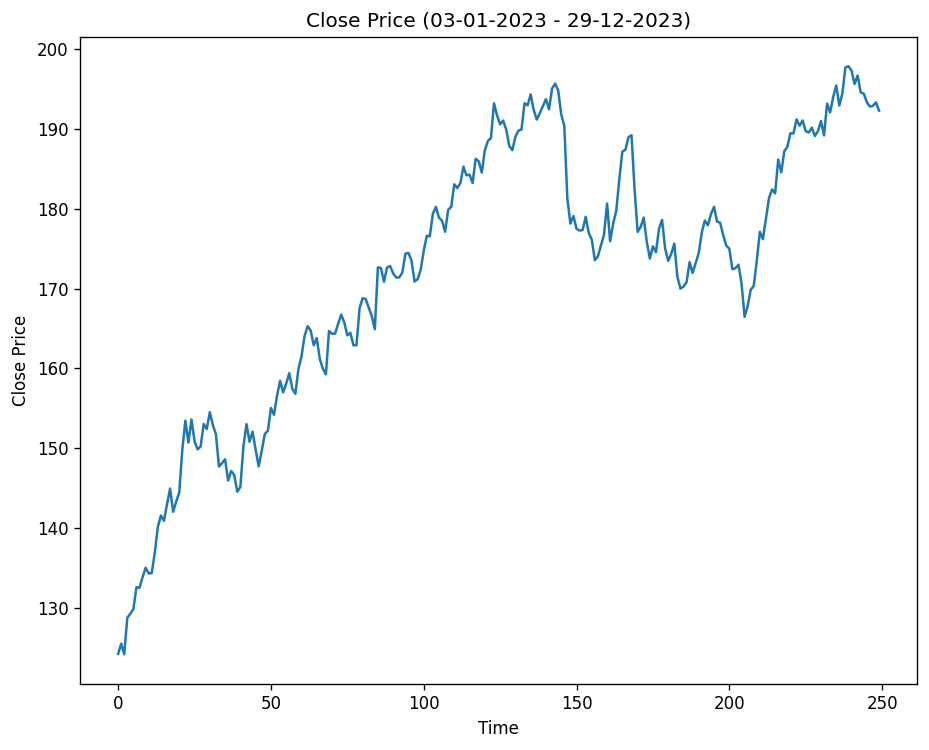

In [ ]:
# Plot Stck price(close) from 03-01-2023 - 29-12-2023
plt.plot(df['Close'])
plt.title('Close Price (03-01-2023 - 29-12-2023)')
plt.xlabel('Time')
plt.ylabel('Close Price')

<Axes: ylabel='Density'>

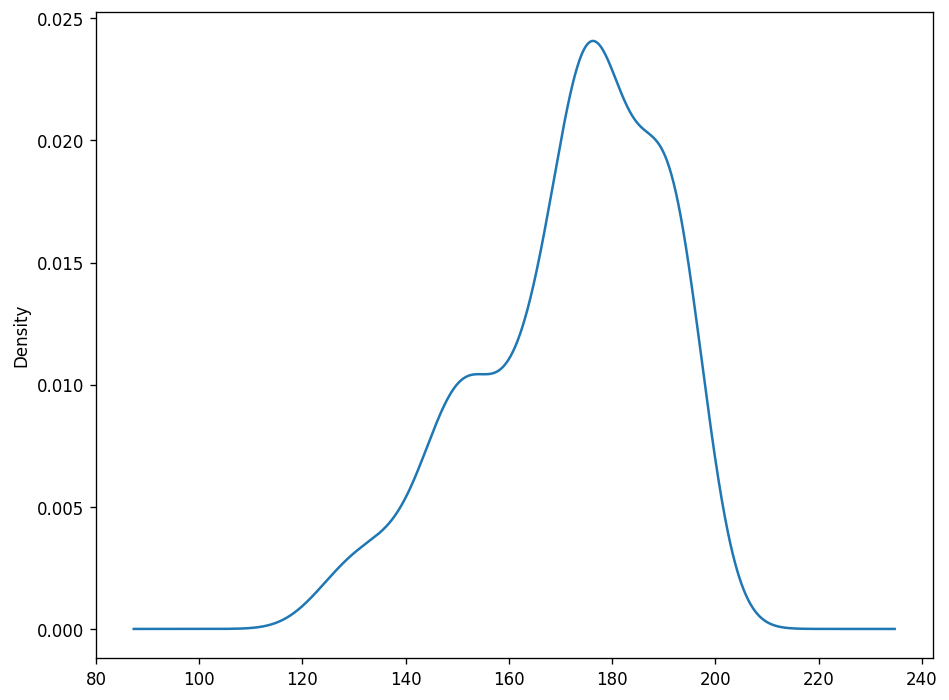

In [ ]:
df_close = df['Close']
df_close.plot(kind='kde')

from this itself we can see that our data is non-stationary and requires differenciation

## First order Differencing

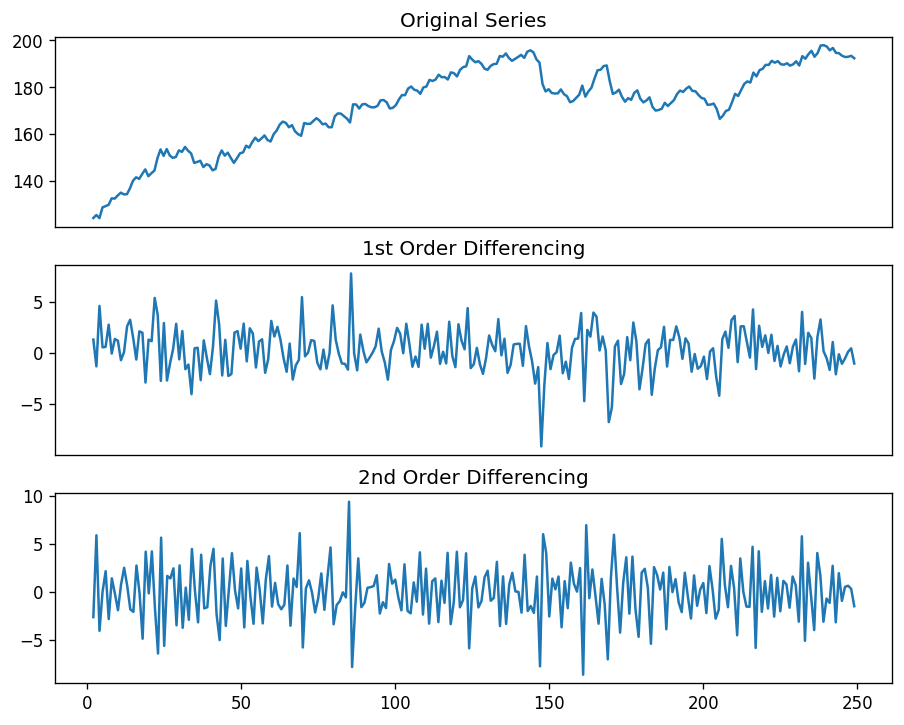

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df.Close); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df.Close.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df.Close.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

Here we can see how the time series has become stationary. One thing which is noticeable here is in first-order differencing we have fewer noises in the data while after 1st order there is an increase in the noise. So we can select 1st order differencing for our model. We can also verify this using an autocorrelation plot.



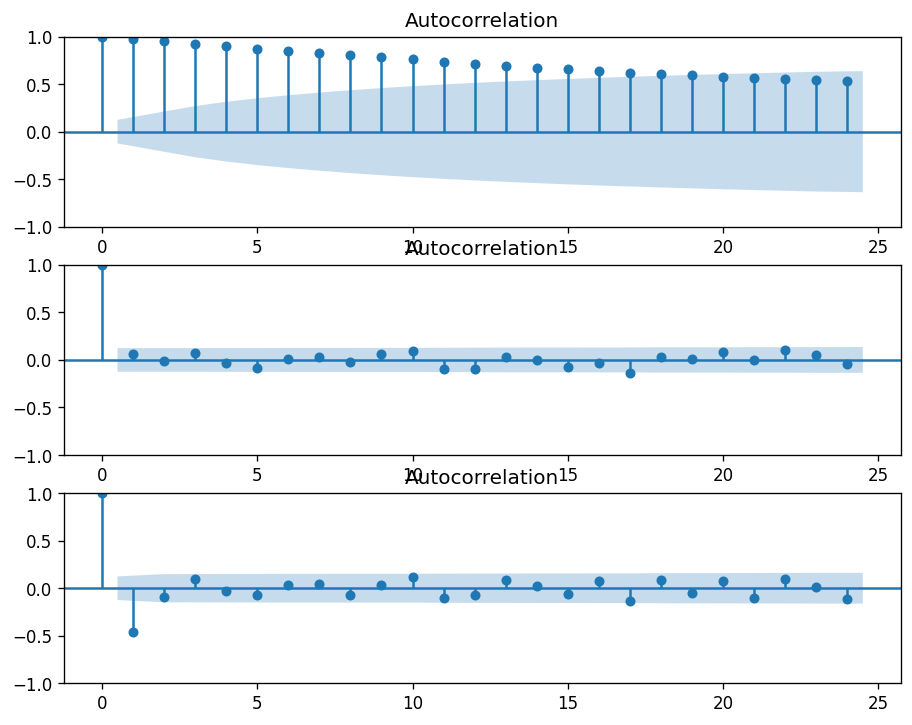

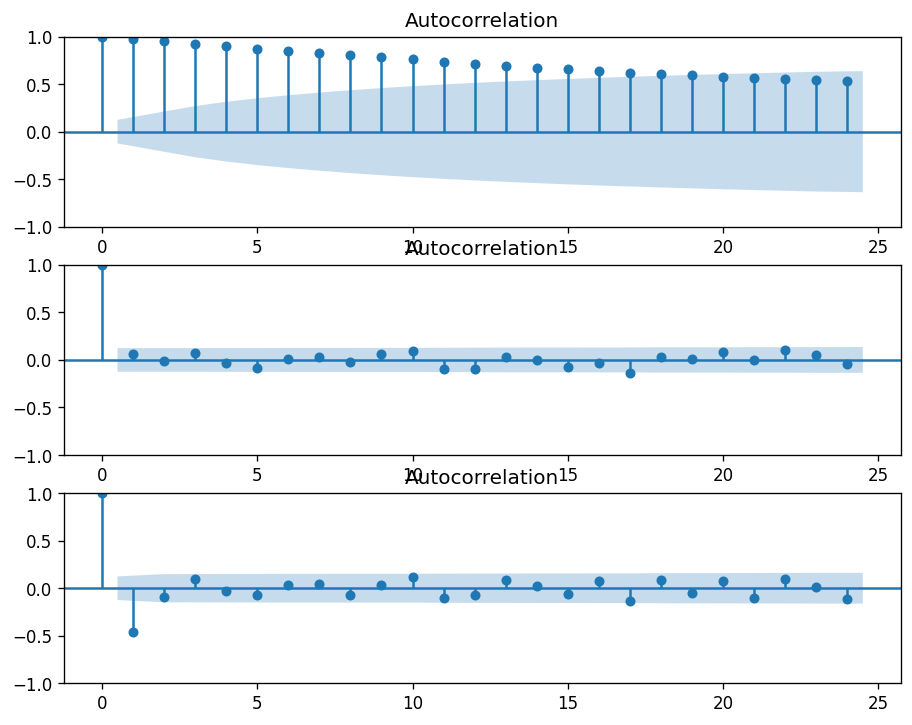

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df.Close, ax=ax1)
plot_acf(df.Close.diff().dropna(), ax=ax2)
plot_acf(df.Close.diff().diff().dropna(), ax=ax3)

Here we can see that in second-order differencing the immediate lag has gone on the negative side, representing that in the second-order the series has become over the difference.



---



## Finding the value of the p parameter


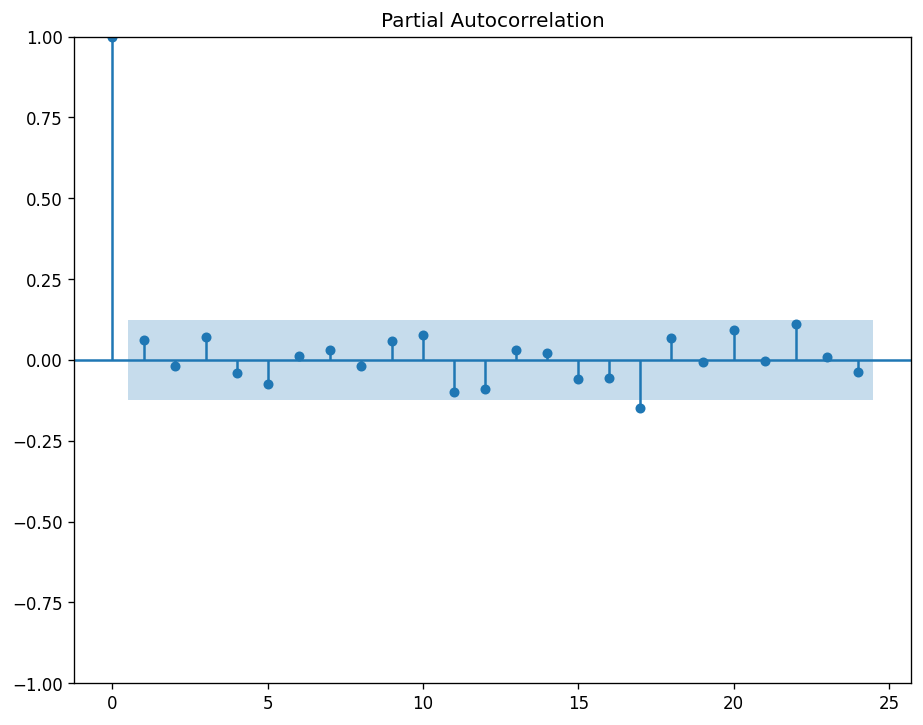

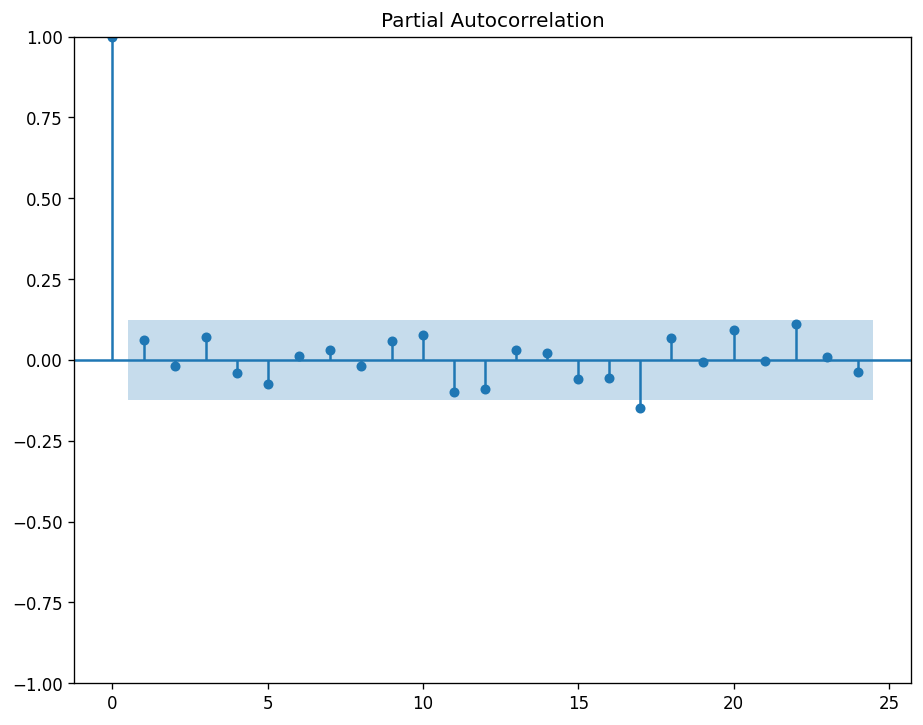

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.Close.diff().dropna())

p=1

## Finding the value of the q parameter


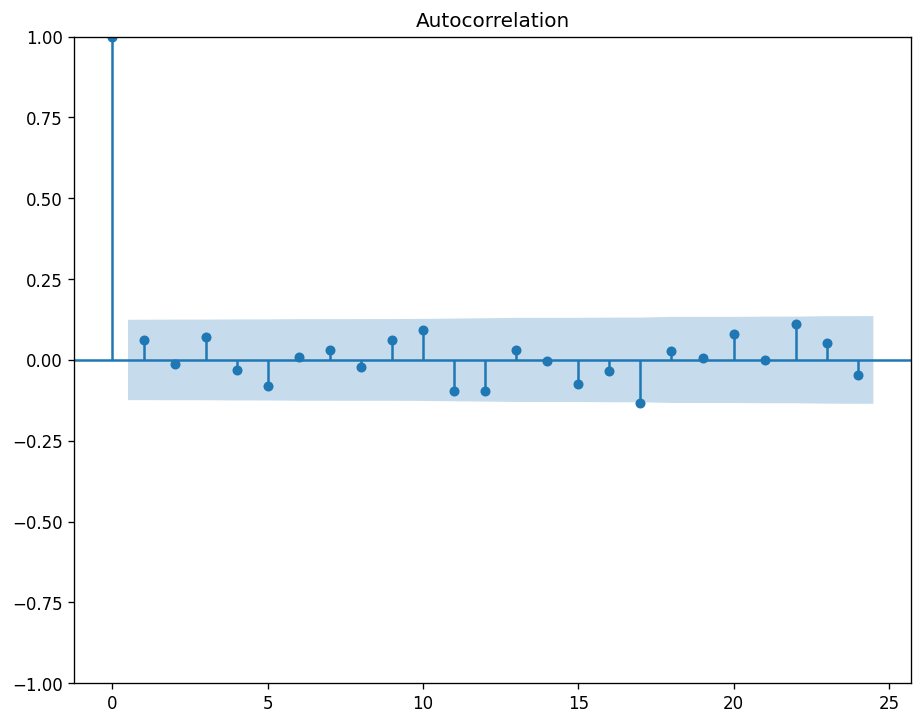

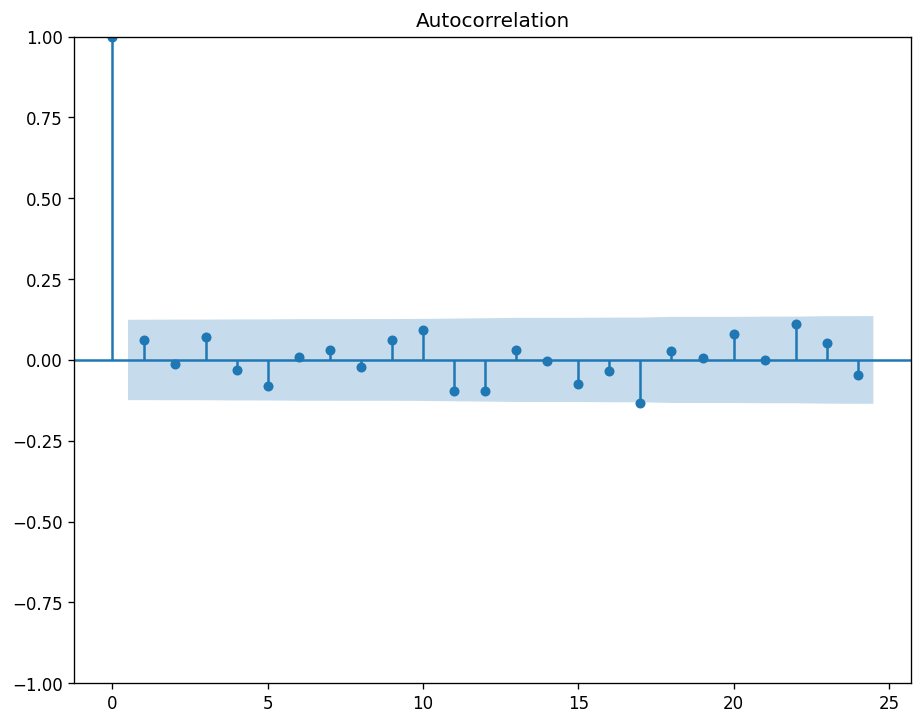

In [ ]:
plot_acf(df.Close.diff().dropna())

q=1

## Building the ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df.Close, order = (1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  250
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -540.379
Date:                Tue, 12 Mar 2024   AIC                           1088.758
Time:                        09:20:59   BIC                           1102.827
Sample:                             0   HQIC                          1094.421
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5604      1.284     -0.436      0.663      -3.077       1.956
ma.L1          0.6395      1.285      0.498      0.619      -1.878       3.157
ma.L2          0.0135      0.150      0.089      0.929      -0.281       0.308
sigma2         4.4927      0.317     14.171      0.000       3.871       5.114
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                35.63
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.22
Prob(H) (two-sided):                  0.72   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

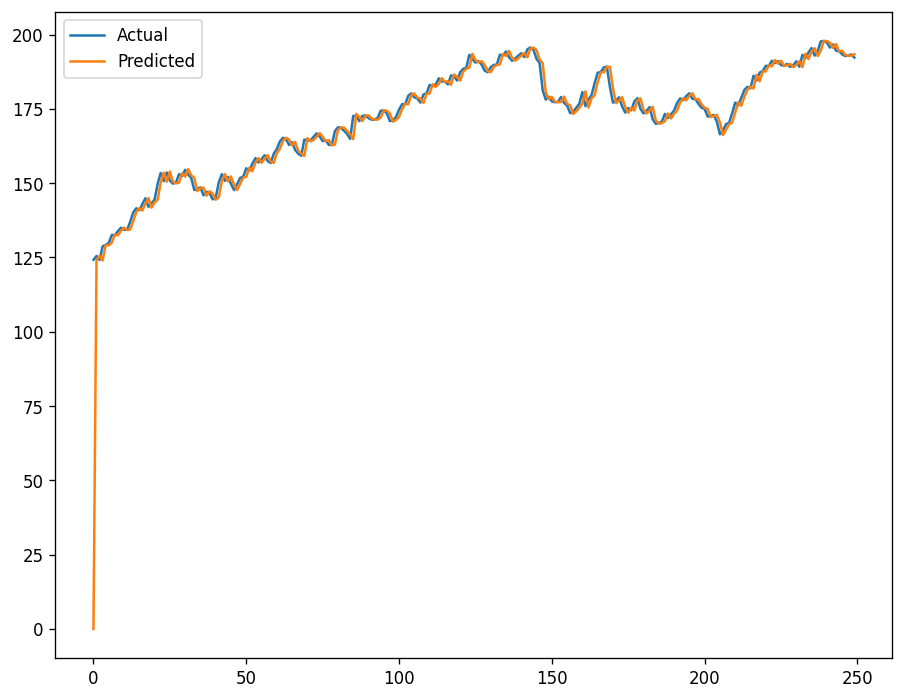

In [ ]:
predicted_values = model_fit.predict(start=0, end=len(df)-1)

# Plot the predicted values against the actual values
plt.plot(df['Close'], label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.legend()
plt.show()